In [16]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor

In [1]:
def separate_single_timeseries(df, paese, prodotto):
    filtrato = df[(df['Country'] == paese) & (df['Product'] == prodotto)]
    filtrato = filtrato.copy()
    return filtrato

def drop_leading_zeros(df):
    """
    Rimuove tutte le righe iniziali del DataFrame finché 'Quantity' == 0.
    Restituisce il DataFrame a partire dal primo valore diverso da zero.
    """
    first_nonzero_idx = df[df["Quantity"] != 0].first_valid_index()
    if first_nonzero_idx is not None:
        return df.loc[first_nonzero_idx:].reset_index(drop=True)
    else:
        return pd.DataFrame(columns=df.columns)

def ultimi_n_zeri(y, n = 5):
    y = y.reshape(-1)
    return (y[-n:] == 0).all()

def my_test_train_split(x, y, last_n_values = 12):
    x_train = x[:-last_n_values]
    x_test = x[-last_n_values:]
    y_train = y[:-last_n_values]
    y_test = y[-last_n_values:]

    return x_train, y_train, x_test, y_test

In [2]:
from scipy.signal import periodogram

def indice_periodicita_spettrale(serie):
    f, Pxx = periodogram(serie)
    Pxx = Pxx[1:]  # Escludi la frequenza 0
    if np.sum(Pxx) == 0:
        return 0
    return np.max(Pxx) / np.sum(Pxx)


def period_by_frekko(y, k):
    periods = []
    losses = []

    for k_val in k:

        li = 0
        for i in range(k_val, len(y)):
            correction = 1 if y[i] == 0 else 0
            li+=(y[i]-y[i-k_val])**2/(y[i]+ correction)

        loss = 1/(len(y)-k_val) * li

        losses.append(loss)
        periods.append(k_val)

    min_i = 0
    min_loss = losses[0]
    for i in range(1, len(periods)):
        if losses[i] < min_loss:
            min_i = i
            min_loss = losses[i]
    return min_i, min_loss

In [6]:
dataframe = pd.read_csv(r"data\01_input_history.csv")
unique_countries = dataframe["Country"].unique()
unique_prods = dataframe["Product"].unique()

In [3]:
# divido il dataset per country e prodotto
# pulizia 0 iniziali
# check su peiodicità
# se periodico ---> stima prossimi picchi
# altrimenti ----> check su ultimi 0 e regressione lineare

In [ ]:
def geo_w(i, N, k):
    return 1/(N//k - i + 1)

def model(df, my_model, threshold_periodicity = 0.8, periods_k = [i for i in range(1, 13)], forecast_steps = 12):
    df = drop_leading_zeros(df)
    N = len(df)
    y = df["Quantity"].values
    print(y)
    
    period, periodicity_loss = period_by_frekko(y, periods_k)
    period += 1
    if periodicity_loss < threshold_periodicity:

        if ultimi_n_zeri(y, period*2):
            predictions = [0 for _ in range(0, forecast_steps)]
        else:
            predictions = []
            den = sum([geo_w(j, N, forecast_steps) for j in range(0, N//period)])
            for i in range(0, forecast_steps):
                num = sum([y[N+i-period - period*j] * geo_w(j, N, period) for j in range(0, N//period)])
                print(num)
                predictions.append(num/den)
    else:
        if ultimi_n_zeri(y, 6):
            predictions = [0 for i in range(0, forecast_steps)]
        else:
            x = [i for i in range(0, N)]
            x_pred = [i for i in range(N, N+forecast_steps)]
            my_model.fit(x, y)
            predictions = my_model.predict(x_pred)
    
    return predictions

In [40]:

prod = "OralEase Plus Toothbrush"
paese = "India"

reduced_dataset = separate_single_timeseries(dataframe, paese, prod)
reduced_dataset = drop_leading_zeros(reduced_dataset)


my_model = RandomForestRegressor(n_estimators=100, random_state=404, criterion="squared_error")

predictions = model(reduced_dataset, my_model)



[400   0   0   0   0   0 375   0   0   0   0   0 378   0   0   0   0   0
 371   0   0   0   0   0 370   0   0   0   0   0 378   0   0   0   0   0
 356   0   0   0   0   0 364   0   0   0   0   0 379   0   0   0   0   0
 379   0   0   0   0   0 389   0   0   0   0   0 403   0   0   0   0   0
 380   0   0   0   0   0 354   0   0   0   0   0 340   0   0   0   0   0
 367   0   0   0   0   0 362   0   0   0   0   0 388   0   0   0   0   0
 366   0   0   0   0   0 367   0   0   0   0   0 388   0   0   0   0   0
 361   0   0   0   0   0 384   0   0   0   0   0 371   0   0   0   0   0
 358   0   0   0   0   0 375   0   0   0   0   0 370   0   0   0   0   0
 401   0   0   0   0   0 368   0   0   0   0   0 371   0   0   0   0   0
 369   0   0   0   0   0 354   0   0   0   0   0 355   0   0   0   0   0
 375   0   0   0   0   0]
1186.4921707920544
0.0
0.0
0.0
0.0
0.0


IndexError: index 204 is out of bounds for axis 0 with size 204

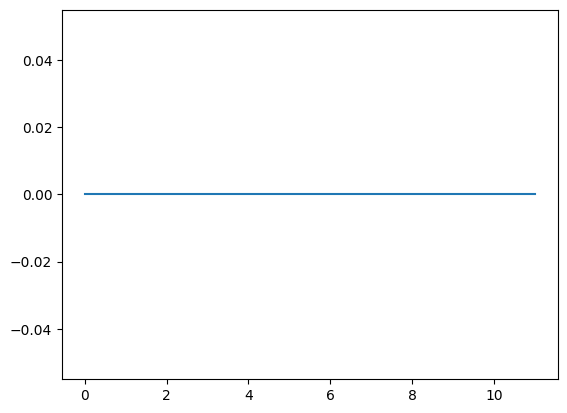

In [36]:
from matplotlib import pyplot as plt
plt.plot([i for i in range (12)], predictions)
plt.show()